# Importing Libraries and Training data file

In [205]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import random
from matplotlib import pyplot

In [170]:
train_data=pd.read_csv('../../input/train.csv',nrows=10_000_000)

# Q1) Visualising and Cleaning Data

In [171]:
train_data.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

# Dropping Null Values

In [172]:
train_data = train_data.dropna()
print(len(train_data))

9999931


In [173]:
train_data.describe() #to check for any abnormalities or cleaning that may be required

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9.999931e+06,9.999931e+06,9.999931e+06,9.999931e+06,9.999931e+06,9.999931e+06
mean,1.133849e+01,-7.250778e+01,3.991936e+01,-7.250897e+01,3.991913e+01,1.684805e+00
std,9.799845e+00,1.299413e+01,9.322519e+00,1.287532e+01,9.237280e+00,1.323421e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


# Since this is a Taxi data, Passenger count in a single cab cannot be more than 20(at max). However we find many of those rows with Passengers>8. We need to handle this

In [174]:
train_data= train_data[train_data['passenger_count']<=8]
train_data= train_data[train_data['passenger_count']>0]
train_data.iloc[:10]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [175]:
print(len(train_data))

9964653


# Since fare cannot be negative. Removing those rows.

In [176]:
train_data= train_data[train_data['fare_amount']>0]
print(len(train_data))

9963967


# Calculating Euclidean Distance

In [177]:
from scipy.stats.stats import pearsonr

In [178]:
def add_euclidean(df):
    dlat=(df.dropoff_latitude - df.pickup_latitude).abs()*110.574
    dlon=(df.dropoff_longitude - df.pickup_longitude).abs()*110.574
    df['Euc_dist']=(dlat**2 + dlon**2)**0.5
    
add_euclidean(train_data)
train_data['Euc_dist'].shape

(9963967,)

# Now Euclidean distance for a ride within New york city cannot be more than 50 kms (roughly). Handling this case.

In [179]:
train_data=train_data[train_data['Euc_dist']<50]

# Also, the Distance should either be greater than 0

In [180]:
train_data=train_data[train_data['Euc_dist']>0]

# Filtering the coordinates of New York where reasonable taxi rides could happen (Coordinates of NYC are 40.7128° N, 74.0060° W )

In [181]:
train_data=train_data[(train_data['pickup_longitude']<=-71) & (train_data['pickup_longitude']>=-76)]
train_data=train_data[(train_data['pickup_latitude']>=38) & (train_data['pickup_latitude']<=43)]
train_data=train_data[(train_data['dropoff_longitude']<=-71) & (train_data['dropoff_longitude']>=-76)]
train_data=train_data[(train_data['dropoff_latitude']>=38) & (train_data['dropoff_latitude']<=43)]

# Filtering out fare amount that is not in some reasonable proportion of the distance travelled. And max fare is unlikely to go above usd 150

In [182]:
train_data=train_data[train_data['fare_amount']<(50*train_data['Euc_dist'])]
train_data=train_data[train_data['fare_amount']>(0.01*train_data['Euc_dist'])]
train_data=train_data[train_data['fare_amount']<150]

# Adding time of day and Seconds (Total time of the day in seconds)

In [183]:
def add_seconds(df):
    df['time_of_day'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))
    df['seconds'] = df['time_of_day'].apply((lambda x: x.hour*3600+x.minute*60+x.second))
add_seconds(train_data)
train_data['seconds'].shape

(9587961,)

# Q2) Calculating pearson correlation

Between Euclidean Distance and Fare amount

In [184]:
pearsonr(train_data['Euc_dist'],train_data['fare_amount'])

(0.9117735692525387, 0.0)

Between time of day (in seconds) and Euclidean distance

In [185]:
pearsonr(train_data['seconds'],train_data['Euc_dist'])

(-0.031147815557751247, 0.0)

Between time of day (in seconds) and fare amount

In [186]:
pearsonr(train_data['seconds'],train_data['fare_amount'])

(-0.01723488643424979, 0.0)

# Q3) Plotting graphs and visualising

For Euclidean Distance and Fare amount

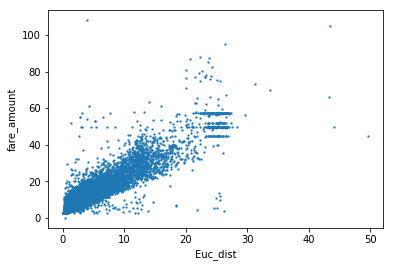

In [164]:
plot=train_data.iloc[:20000].plot.scatter('Euc_dist', 'fare_amount',s=1.5)
fig=plot.get_figure()
fig.savefig('plot1.png')

For time of day (in seconds) and Euclidean distance

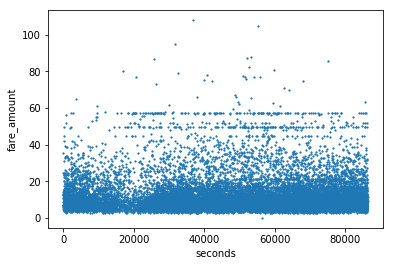

In [113]:
plot=train_data.iloc[:20000].plot.scatter('seconds', 'fare_amount',s=1.5)
fig=plot.get_figure()
fig.savefig('plot2.png')

For time of day (in seconds) and fare amount

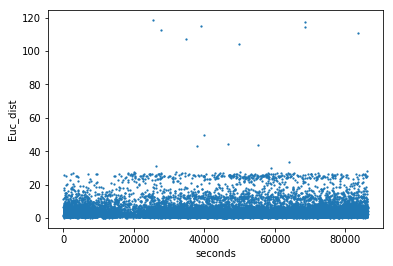

In [114]:
plot=train_data.iloc[:20000].plot.scatter('seconds', 'Euc_dist',s=1.5)
fig=plot.get_figure()
fig.savefig('plot3.png')

# Q4) Exciting plot of own

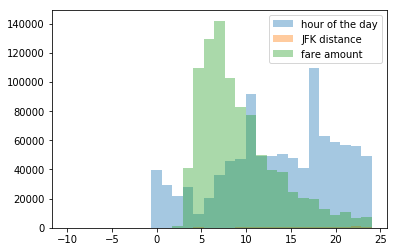

In [229]:
x = train_data['hour']
y = train_data['Euc_dist']
z= train_data['jfk_dist']
a=train_data['fare_amount']
bins = np.linspace(-10, 24, 30)

pyplot.hist(x, bins, alpha=0.4, label='hour of the day')
pyplot.hist(z, bins, alpha=0.4, label='JFK distance')
pyplot.hist(a, bins, alpha=0.4, label='fare amount')
pyplot.legend(loc='upper right')
pyplot.savefig('plot5.png')
pyplot.show()

We have drawn a histogram to show the relation between Hour of the day, JFK distance, Fare amount and the no. of rides.
Here we can see that the number of rides actually vary depending on what time of the day it is.
We can see that

i) The number of rides are minimum around 5AM in the morning. Its at peak at 7pm in the night.

ii) We see that least distances to JFK airport are at night which shows that most people travel to airports early mornings to late night.

iii) We also see that the fare amount is most during peak hours of the day as expected.

iv) by jfk_dist , we see that most of the farthest rides to the airports are at the peak office hours meaning that no one goes to airports at that time.

# Q5) Adding new features of own to improve performance

In [187]:
def add_haversine(df):
    radius = 6371 # km

    dlat = np.radians(df.dropoff_latitude - df.pickup_latitude)
    dlon = np.radians(df.dropoff_longitude - df.pickup_longitude)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(df.pickup_latitude)) \
        * np.cos(np.radians(df.dropoff_latitude)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    df['haversine'] = radius * c
def add_jfk_dist(df):
    jfk_coord = (40.639722, -73.778889)
    pick_lat=(jfk_coord[0] - df.pickup_latitude).abs()*110.574
    pick_lon=(jfk_coord[1] - df.pickup_longitude).abs()*110.574
    drop_lat=(df.dropoff_latitude - jfk_coord[0]).abs()*110.574
    drop_lon=(df.dropoff_longitude - jfk_coord[1]).abs()*110.574
    pick_dist=(pick_lat**2 + pick_lon**2)**0.5
    drop_dist=(drop_lat**2 + drop_lon**2)**0.5
    df['jfk_dist']=pick_dist+drop_dist
def add_tsq_dist(df):
    tsq_coord= (40.7589,-73.9851)
    pick_lat=(tsq_coord[0] - df.pickup_latitude).abs()*110.574
    pick_lon=(tsq_coord[1] - df.pickup_longitude).abs()*110.574
    drop_lat=(df.dropoff_latitude - tsq_coord[0]).abs()*110.574
    drop_lon=(df.dropoff_longitude - tsq_coord[1]).abs()*110.574
    pick_dist=(pick_lat**2 + pick_lon**2)**0.5
    drop_dist=(drop_lat**2 + drop_lon**2)**0.5
    df['tsq_dist']=pick_dist+drop_dist
def add_date_info(df):
        df['hour'] = df.time_of_day.apply(lambda x: x.hour)
        df['weekday'] = df.time_of_day.apply(lambda x: x.weekday())
        df['month'] = df.time_of_day.apply(lambda x: x.month)
        df['year'] = df.time_of_day.apply(lambda x: x.year)
def add_dist_sea(df): #distance of a point near the sea border.
    tsq_coord= (40.7016,-74.0162)
    pick_lat=(tsq_coord[0] - df.pickup_latitude).abs()*110.574
    pick_lon=(tsq_coord[1] - df.pickup_longitude).abs()*110.574
    drop_lat=(df.dropoff_latitude - tsq_coord[0]).abs()*110.574
    drop_lon=(df.dropoff_longitude - tsq_coord[1]).abs()*110.574
    pick_dist=(pick_lat**2 + pick_lon**2)**0.5
    drop_dist=(drop_lat**2 + drop_lon**2)**0.5
    df['dist_sea']=pick_dist+drop_dist
def add_dist_stonybrook(df): #distance from stony brook
    tsq_coord= (40.9054,-73.1075)
    pick_lat=(tsq_coord[0] - df.pickup_latitude).abs()*110.574
    pick_lon=(tsq_coord[1] - df.pickup_longitude).abs()*110.574
    drop_lat=(df.dropoff_latitude - tsq_coord[0]).abs()*110.574
    drop_lon=(df.dropoff_longitude - tsq_coord[1]).abs()*110.574
    pick_dist=(pick_lat**2 + pick_lon**2)**0.5
    drop_dist=(drop_lat**2 + drop_lon**2)**0.5
    df['dist_sb']=pick_dist+drop_dist
add_dist_sea(train_data)
add_dist_stonybrook(train_data)
add_date_info(train_data)
add_haversine(train_data)
add_jfk_dist(train_data)
add_tsq_dist(train_data)
train_data.iloc[:5]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Euc_dist,time_of_day,seconds,dist_sea,dist_sb,hour,weekday,month,year,haversine,jfk_dist,tsq_dist
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.043359,2009-06-15 17:26:21,62781,38.472300,167.911619,17,0,6,2009,1.030764,22.169331,32.795426
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.812269,2010-01-05 16:52:16,60736,10.856660,200.084474,16,1,1,2010,8.450134,54.566269,8.912530
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.511993,2011-08-18 00:35:00,2100,13.641321,197.289423,0,3,8,2011,1.389525,52.730051,1.515087
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.801997,2012-04-21 04:30:42,16242,11.557692,198.214221,4,5,4,2012,2.799270,52.150671,3.577528
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2.152822,2010-03-09 07:51:00,28260,20.287110,191.217386,7,1,3,2010,1.999157,50.575842,6.310386


# Q6) Using Linear Regression

In [188]:
def get_input_matrix(df):
    return np.column_stack((df.Euc_dist,df.passenger_count,df.hour,df.weekday,df.pickup_latitude,df.pickup_longitude,df.dropoff_latitude,df.dropoff_longitude,df.jfk_dist,df.tsq_dist,df.month,df.year,df.dist_sb,df.dist_sea,np.ones(len(df))))

train_X = get_input_matrix(train_data)
train_y = np.array(train_data['fare_amount'])
print(train_X.shape)
print(train_y.shape)

(9587961, 15)
(9587961,)


In [189]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)
model1 = LinearRegression()
model1.fit(X_train, y_train)
model1.score(X_test, y_test)

0.8470250353479413

Checking the coefficients of the features and deducing which ones are the most important

In [165]:
model1.coef_

array([ 2.01539488e+00,  3.72045156e-02,  1.16916095e-02, -4.08946086e-02,
        6.04529442e+00,  1.73386899e+00, -1.52733650e+01, -1.47549231e+01,
        6.09008012e-02,  1.18360042e-03,  6.91964776e-02,  5.24138292e-01,
       -6.65390018e-02,  1.01014863e-02,  0.00000000e+00])

# Q7) Identifying external dataset that may help

The following are some of the datasets that I found interesting which could give me some idea about my predictions:

i) My uber drives: Contains details of all the uber trips for a single customer. Shows the information about how an average customer travels during different times of the day, to different places and for different purposes. Gave me ideas to include features such as Days of day(Holiday or not) and toll routes.

ii) Taxi Industry statistics: Shows data like how much taxi licences were issued, how many drivers driving on road and other legal information which could help identify the number of rides taken that year or even the fare amount.

iii) Chicago taxi rides: Gives information about the taxi rides for chicago. It analysed effects of whether people travel by metro or takes taxi for small distances due to chicago’s extensive metro system. Since NYC subways is the same, this is one useful feature that could be accommodated.

iv) Airport Traffic data: Was able to successfully deduce features like frequent airport timings and peak times to accommodate to my data.

Airport Traffic data: https://toolbox.google.com/datasetsearch/search?query=Airport%20traffic%20data&docid=hKv9qr%2BVL5k5DkXFAAAAAA%3D%3D
 
My uber drives: https://www.kaggle.com/zusmani/uberdrives

# Q8) Using a better model i.e. Random Forests instead of Linear regression to improve performance

Random forests is a high level ML algorithm that uses many trees to make a prediction. But since Random forests take time to make predictions you have to zero down on an ideal number of n-estimators(trees) that you can use for prediction. I used 24 trees on a subset of my data. The model performed exceptionally well. The OOB score was around 0.85 and When I submitted my predictions through kaggle, I was able to jump almost 150 Places on the leaderboard. My RMSE came out to be as good as 3.88649(Attached screenshot). Shows the power of Random forests when used ideally.

In [ ]:
 model2= RandomForestRegressor(n_estimators=24,oob_score=True,random_state=42)
 model2.fit(train_X,train_y)

Evaluating the model

In [ ]:
 model2.oob_score_

# Boosting using lgbm

To boost my predictions further I used lightgbm lgbm classifier. I used default parameters for the same. LGBM is an advanced ML classifier that uses decision making and is very optimal especially on these types of problems. I installed lightgbm and imported lgbm before using. The result was that My RMSE score got a huge to 3.192 after applying LGBM and I achieved my best ever ranking of 414! This shows that LGBM is indeed the best and it used all my features perfectly to make very accurate predictions.

In [166]:
params = {
        'nthread': -1,  
    }
#Default Parameters

train_set = lgbm.Dataset(train_X, train_y, silent=True)
model3 = lgbm.train(params, train_set = train_set, num_boost_round=300)

# Q9) Importing test data

In [190]:
test_df = pd.read_csv('../../input/test.csv')
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [191]:
test_df.iloc[:5]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


# Creating prediction file for the test data

In [192]:
#Setting up the test data
add_euclidean(test_df)
add_seconds(test_df)
add_haversine(test_df)
add_jfk_dist(test_df)
add_tsq_dist(test_df)
add_date_info(test_df)
add_dist_sea(test_df)
add_dist_stonybrook(test_df)
test_X = get_input_matrix(test_df)

#Doing the final prediction on the test data
test_y_predictions = model3.predict(test_X, num_iteration = model3.best_iteration)

# Write the predictions to a CSV file
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('sample_submission_Linear.csv', index = False)